In [1]:
from fastai import *
from fastai.vision import *

%matplotlib inline

In [2]:
PATH = os.path.abspath('..')

sys.path.append(f'{PATH}/src')
from mxresnet import *
from ranger import Ranger

Mish activation loaded...
Mish activation loaded...


In [3]:
seed = 12345

In [4]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1., max_rotate=15., max_lighting=0, max_warp=0)

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]


bs = 32
sz = 224

In [5]:
src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['logfgas'],  label_cls=FloatList)
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [6]:
learn = Learner(data, model=mxresnet50(), 
                opt_func=partial(Ranger),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(2048, 1, bias=True)


In [7]:
learn.load('mxresnet50-range_100ep');

set state called


In [11]:
learn.data.valid_dl.batch_size = 32

In [12]:
fgas_pred, fgas_true = learn.get_preds()

In [14]:
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2410)

In [13]:
results = pd.DataFrame({'fgas_pred': fgas_pred.squeeze(), 'fgas_true': fgas_true.squeeze()})
results['AGCNr'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('AGCNr', drop=True, inplace=True)

results.sample(3)

,fgas_pred,fgas_true
AGCNr,,
258422,0.714514,0.987363
202649,0.209043,-0.218964
251098,-0.105456,-0.178010


In [15]:
results.to_csv(f'{PATH}/results/predictions/best_a40-50.csv')

In [26]:
results['d_fgas'] = results.fgas_pred - results.fgas_true

results.index = results.index.astype(np.int64)

# Crossmatch with other data

In [17]:
data = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv', index_col='AGCNr')

In [28]:
df = results.join(data, on='AGCNr', how='left')
df.sample(3)

,fgas_pred,fgas_true,d_fgas,Unnamed: 0,DR7ObjID,logMHI,logMstar,logSFR,Zgas,logfgas,logsSFR
AGCNr,,,,,,,,,,,
224230,0.869148,1.040394,-0.171245,7257,588010878228103291,7.64,6.599606,-2.187329,7.949226,1.040394,-8.786935
240300,0.231325,0.368782,-0.137457,9302,587736809378742296,10.08,9.711218,0.311851,8.873256,0.368782,-9.399367
232865,0.689071,0.699099,-0.010028,7702,588010878767202514,9.03,8.330901,-1.092455,8.023540,0.699099,-9.423356


# Check for correlations

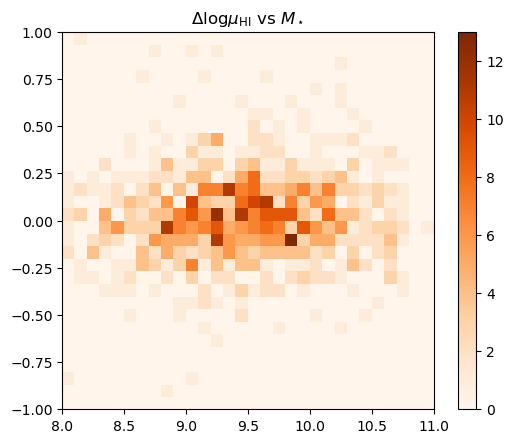

In [37]:
plt.figure(figsize=(6, 5), dpi=100)
plt.title(r'$\Delta \log\mu_{\rm HI}$ vs $M_\star$')
plt.hist2d(df.logMstar, df.d_fgas, cmap='Oranges', bins=30, range=[(8, 11), (-1, 1)]);
plt.colorbar()

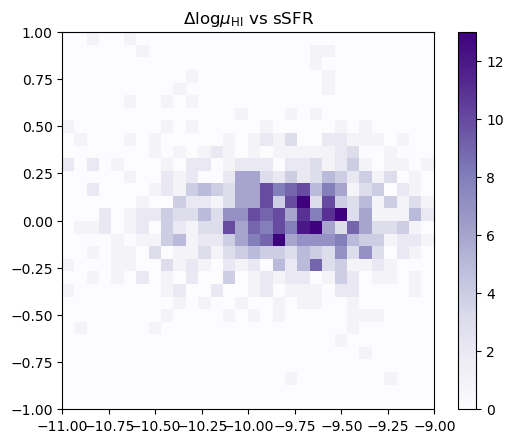

In [38]:
plt.figure(figsize=(6, 5), dpi=100)
plt.title(r'$\Delta \log\mu_{\rm HI}$ vs sSFR')
plt.hist2d(df.logsSFR, df.d_fgas, cmap='Purples', bins=30, range=[(-11, -9), (-1, 1)]);
plt.colorbar()

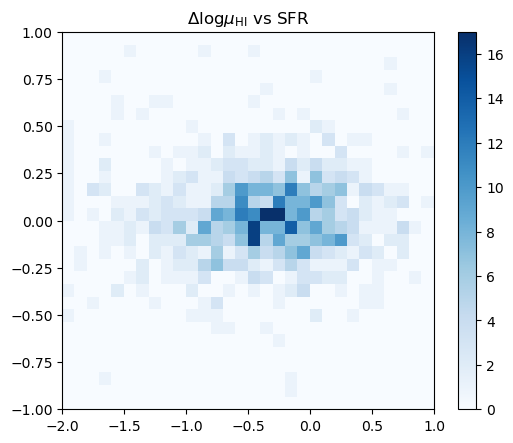

In [40]:
plt.figure(figsize=(6, 5), dpi=100)
plt.title(r'$\Delta \log\mu_{\rm HI}$ vs SFR')
plt.hist2d(df.logSFR, df.d_fgas, cmap='Blues', bins=30, range=[(-1.5, 1), (-1, 1)]);
plt.colorbar()

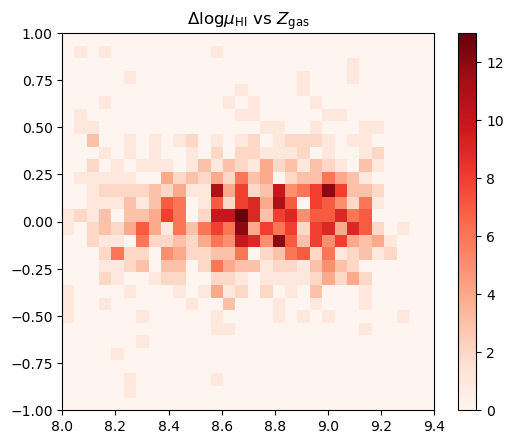

In [47]:
plt.figure(figsize=(6, 5), dpi=100)
plt.title(r'$\Delta \log\mu_{\rm HI}$ vs $Z_{\rm gas}$')
plt.hist2d(df.Zgas, df.d_fgas, cmap='Reds', bins=30, range=[(8.0, 9.4), (-1, 1)]);
plt.colorbar()